In [149]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2

import pandas as pd
import geopandas as gpd

from tobler.area_weighted import area_interpolate
from sklearn.metrics import classification_report

import statsmodels.api as sm

# Plotting
import matplotlib as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

In [2]:
# Shape file of State of Kansas
fp= 'C:/Users/sarahann.USERS/Desktop/code/cb_2018_us_state_500k.shp' # state shape file. 
kansas = gpd.read_file(fp)
ks_map = kansas.NAME.isin(['Kansas']) 
ks_map = kansas[ks_map].loc[0:]
ks_map.to_crs(epsg=5070, inplace=True)

# County shape file, use for county lines
fp= 'C:/Users/sarahann.USERS/Desktop/code/us_county/US_County_Boundaries.shp' # county file

map_county = gpd.read_file(fp)
# Delete Non-contingous US counties 
ks_county = map_county.STATE.isin(['Kansas'])  
map_county = map_county[ks_county].loc[0:]
map_county.to_crs(epsg=5070, inplace=True)

cluster = gpd.read_file('C:/Users/sarahann.USERS/Desktop/scripts_jp/agroecology_paper/data_processing/clusters.shape/clusters.shp')
cluster.head(1)

,elevation,temp,precip,paws_050,om_kg_sq_m,sand,silt,clay,pet,depth_adj,kmean2_clu,kmean_5_cl,kmean_6_cl,kmean_7_cl,kmean_11_c,geometry
0,1059.0,11.0,461.99998,10.200312,11.600936,36.791890,48.006241,15.402184,1293.999923,35.999998,0,1,3,6,5,"POLYGON ((-102.03311 39.99941, -102.04197 39.9..."
1,1028.0,11.0,460.99998,9.952817,13.037917,41.436857,44.328141,13.974322,1294.000000,150.000000,0,2,4,3,8,"POLYGON ((-102.02369 39.99314, -102.03255 39.9..."
2,1025.0,11.0,462.00000,9.419477,12.653916,36.736107,47.196245,16.109182,1293.999923,150.000000,0,2,4,3,8,"POLYGON ((-102.03311 39.99941, -102.03199 39.9..."


**Load Cause of Loss as a Percent of All Types of Loss**

In [3]:
loss_type_per= gpd.read_file('C:/Users/sarahann.USERS/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/loss_type_per.shape/loss_type_per.shp')          
loss_type_per.head(2)

,STFIPS,CTFIPS,STATE,COUNTY,VERSION,Shape_Leng,Shape_Area,ARPI/SCO/E,All Other,Asian Soyb,...,Hot Wind,Insects,Mycotoxin,Other (Sno,Plant Dise,Wind/Exces,ARPI/SCO/S,ARPI/SCO_1,Falling Nu,geometry
0,20,20023,Kansas,cheyenne,05,2.145800,0.277993,0.024691,0.0,0.0,...,0.041975,0.007407,0.002469,0.022222,0.024691,0.046914,0.037037,0.039506,0.0,"POLYGON ((-102.04981 39.57406, -102.04993 39.5..."
1,20,20153,Kansas,rawlins,05,2.213924,0.291303,0.025210,0.0,0.0,...,0.016807,0.000000,0.000000,0.025210,0.008403,0.067227,0.042017,0.037815,0.0,"POLYGON ((-101.41391 39.56832, -101.41361 39.5..."
2,20,20089,Kansas,jewell,05,2.016403,0.249024,0.016241,0.0,0.0,...,0.006961,0.009281,0.000000,0.009281,0.006961,0.025522,0.027842,0.041763,0.0,"POLYGON ((-98.50527 39.56760, -98.50530 39.567..."


In [5]:
# Set to common crs projection 
loss_type_per.to_crs(epsg=5070, inplace=True)
cluster.to_crs(epsg=5070, inplace=True)
loss_type_per.crs == cluster.crs

True

In [85]:
# Interpolate to Dimension of Cluster Grid
loss_per_county = area_interpolate(source_df= loss_type_per, target_df= cluster , intensive_variables=['ARPI/SCO/E', 'All Other', 'Asian Soyb', 'Cold Wet W',
       'Cold Winte', 'Drought', 'Excess Moi', 'Fire', 'Flood', 'Freeze',
       'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Mycotoxin',
       'Other (Sno', 'Plant Dise', 'Wind/Exces', 'ARPI/SCO/S', 'ARPI/SCO_1',
       'Falling Nu'])

loss_per_county=loss_per_county.merge(cluster, on='geometry')
loss_per_county.head(2)

,ARPI/SCO/E,All Other,Asian Soyb,Cold Wet W,Cold Winte,Drought,Excess Moi,Fire,Flood,Freeze,...,sand,silt,clay,pet,depth_adj,kmean2_clu,kmean_5_cl,kmean_6_cl,kmean_7_cl,kmean_11_c
0,0.024691,0.0,0.0,0.02716,0.02963,0.274074,0.096296,0.0,0.002469,0.037037,...,36.791890,48.006241,15.402184,1293.999923,35.999998,0,1,3,6,5
1,0.024691,0.0,0.0,0.02716,0.02963,0.274074,0.096296,0.0,0.002469,0.037037,...,41.436857,44.328141,13.974322,1294.000000,150.000000,0,2,4,3,8
2,0.024691,0.0,0.0,0.02716,0.02963,0.274074,0.096296,0.0,0.002469,0.037037,...,36.736107,47.196245,16.109182,1293.999923,150.000000,0,2,4,3,8


In [178]:
#Set X and y values for loss type
X = loss_per_county[['ARPI/SCO/E', 'All Other', 'Asian Soyb', 'Cold Wet W',
       'Cold Winte', 'Drought', 'Excess Moi', 'Fire', 'Flood', 'Freeze',
       'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Mycotoxin',
       'Other (Sno', 'Plant Dise', 'Wind/Exces', 'ARPI/SCO/S', 'ARPI/SCO_1',
       'Falling Nu']]
y = loss_per_county['kmean_5_cl'].astype("category")

In [ ]:
# Do a grid search to itentify the optimal set of loss causes for a model 

pipeline = Pipeline([('selector',SelectKBest(f_regression)),('model',LogisticRegression(multi_class='multinomial', max_iter=1000))])

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k':[3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'model__penalty':['none', 'l1', '12', 'elasticnet'], 'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}, #
    n_jobs=-1,
    scoring='f1_weighted',
    cv=5,
    verbose=3
)

search.fit(X,y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


In [180]:
# Look at optimal parameters
print(search.best_params_)
print (search.best_score_)

{'selector__k': 11}
-1.0365059288103466


In [181]:
# Select the number of features based on the optimal feature number 

fs = SelectKBest(score_func=f_classif, k=search.best_params_['selector__k'])
# apply feature selection
fit = fs.fit(X, y)

print(fit.pvalues_)
print(fit.scores_)

X.columns[fs.get_support()]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  2264.67333107  14067.0356832    3161.98359272   7280.70437912
  40775.61585321  10877.62493557 121150.94786923   2730.77301645
  41423.29863597  60120.03099055   4504.07860726 118562.37005726
   9057.07403484  41024.27584372   3231.09634209   5131.13199049
  23526.84245321  57179.97428152  66363.21326328   2043.09309444
  11828.31477348   1000.86761307]


Index(['All Other', 'Cold Winte', 'Excess Moi', 'Flood', 'Freeze', 'Hail',
       'Hot Wind', 'Other (Sno', 'Plant Dise', 'Wind/Exces', 'ARPI/SCO_1'],
      dtype='object')

In [182]:
X[list(X.columns[fs.get_support()])]

,All Other,Cold Winte,Excess Moi,Flood,Freeze,Hail,Hot Wind,Other (Sno,Plant Dise,Wind/Exces,ARPI/SCO_1
0,0.0,0.02963,0.096296,0.002469,0.037037,0.232099,0.041975,0.022222,0.024691,0.046914,0.039506
1,0.0,0.02963,0.096296,0.002469,0.037037,0.232099,0.041975,0.022222,0.024691,0.046914,0.039506
2,0.0,0.02963,0.096296,0.002469,0.037037,0.232099,0.041975,0.022222,0.024691,0.046914,0.039506
3,0.0,0.02963,0.096296,0.002469,0.037037,0.232099,0.041975,0.022222,0.024691,0.046914,0.039506
4,0.0,0.02963,0.096296,0.002469,0.037037,0.232099,0.041975,0.022222,0.024691,0.046914,0.039506
...,...,...,...,...,...,...,...,...,...,...,...
254937,0.0,0.00000,0.552632,0.086124,0.002392,0.014354,0.002392,0.004785,0.000000,0.004785,0.019139
254938,0.0,0.00000,0.552632,0.086124,0.002392,0.014354,0.002392,0.004785,0.000000,0.004785,0.019139
254939,0.0,0.00000,0.552632,0.086124,0.002392,0.014354,0.002392,0.004785,0.000000,0.004785,0.019139
254940,0.0,0.00000,0.552632,0.086124,0.002392,0.014354,0.002392,0.004785,0.000000,0.004785,0.019139


In [183]:
X = X[list(X.columns[fs.get_support()])]
mnlogit_mod = sm.MNLogit(y, X)
mnlogit_fit = mnlogit_mod.fit(maxiter=158000, method='bfgs')

print (mnlogit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.728064
         Iterations: 425
         Function evaluations: 428
         Gradient evaluations: 428
                          MNLogit Regression Results                          
Dep. Variable:             kmean_5_cl   No. Observations:               254942
Model:                        MNLogit   Df Residuals:                   254898
Method:                           MLE   Df Model:                           40
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                  0.5419
Time:                        21:19:24   Log-Likelihood:            -1.8561e+05
converged:                       True   LL-Null:                   -4.0520e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
kmean_5_cl=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
All Other     -140.3118      1.

**Load Crop Specific Indemnity to Liability Ratio**

In [ ]:
liab_ratio_by_crop= gpd.read_file('C:/Users/sarahann.USERS/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/liab_ratio_by_crop.shape/liab_ratio_by_crop.shp')
liab_ratio_by_crop.to_crs(epsg=5070, inplace=True)
print(liab_ratio_by_crop.columns.unique())
liab_ratio_by_crop.dropna(inplace=True)
#liab_ratio_by_crop.fillna(0, inplace=True)
liab_ratio_by_crop.head()

In [131]:
liab_ratio_by_crop = area_interpolate(source_df= liab_ratio_by_crop, target_df= cluster , intensive_variables=['Annual For', 'Barley', 'Canola', 'Corn', 'Cotton',
       'Dry Beans', 'Dry Peas', 'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet',
       'Oats', 'Onions', 'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame',
       'Silage Sor', 'Soybeans', 'Sunflowers', 'Triticale', 'Wheat'])

liab_ratio_by_crop=liab_ratio_by_crop.merge(cluster, on='geometry')
print(liab_ratio_by_crop.columns.unique())

liab_ratio_by_crop.head(2)

Index(['Annual For', 'Barley', 'Canola', 'Corn', 'Cotton', 'Dry Beans',
       'Dry Peas', 'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet', 'Oats',
       'Onions', 'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame', 'Silage Sor',
       'Soybeans', 'Sunflowers', 'Triticale', 'Wheat', 'geometry', 'elevation',
       'temp', 'precip', 'paws_050', 'om_kg_sq_m', 'sand', 'silt', 'clay',
       'pet', 'depth_adj', 'kmean2_clu', 'kmean_5_cl', 'kmean_6_cl',
       'kmean_7_cl', 'kmean_11_c'],
      dtype='object')


,Annual For,Barley,Canola,Corn,Cotton,Dry Beans,Dry Peas,Grain Sorg,Hemp,Hybrid Sor,...,sand,silt,clay,pet,depth_adj,kmean2_clu,kmean_5_cl,kmean_6_cl,kmean_7_cl,kmean_11_c
0,0.331577,0.117,0.0,0.06987,0.0,0.264475,0.0,0.074648,0.0,0.0,...,36.791890,48.006241,15.402184,1293.999923,35.999998,0,1,3,6,5
1,0.331577,0.117,0.0,0.06987,0.0,0.264475,0.0,0.074648,0.0,0.0,...,41.436857,44.328141,13.974322,1294.000000,150.000000,0,2,4,3,8


In [185]:
X = liab_ratio_by_crop[['Annual For', 'Barley', 'Canola', 'Corn', 'Cotton',
       'Dry Beans', 'Dry Peas', 'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet',
       'Oats', 'Onions', 'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame',
       'Silage Sor', 'Soybeans', 'Sunflowers', 'Triticale', 'Wheat']]

y = liab_ratio_by_crop['kmean_5_cl'].astype("category")

In [198]:
# Do a grid search to itentify the optimal set of crop specific indeminty/liability ratios for a model 

pipeline = Pipeline([('selector',SelectKBest(f_regression)),('model',LogisticRegression(multi_class='multinomial', max_iter=1000))]) #chi2

search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k':[3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15], 'model__penalty':['none', 'l1', '12', 'elasticnet'], 'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}, #
    n_jobs=-1,
    scoring='f1_weighted',
    cv=5,
    verbose=3
)

search.fit(X,y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1675 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 336, in _fit
    X, fitted_transformer = fit_transform_o

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(score_func=<function f_regression at 0x0000028E339298B0>)),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial'))]),
             n_jobs=-1,
             param_grid={'model__penalty': ['none', 'l1', '12', 'elasticnet'],
                         'model__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                           'sag', 'saga'],
                         'selector__k': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22]},
             scoring='f1_weighted', verbose=3)

In [ ]:
# Look at optimal parameters
print(search.best_params_)
print (search.best_score_)

In [192]:
fs = SelectKBest(score_func=chi2, k=search.best_params_['selector__k'])
# apply feature selection
fit = fs.fit(X, y)

print(fit.pvalues_)
print(fit.scores_)

X.columns[fs.get_support()]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[11130.32765789 14067.17574463 18790.78827318 14640.04178082
  6368.25442437  4929.5563431   5141.30691719  4311.57446352
 11643.49564271  8009.62856538  2527.02187596  1819.36144838
  8233.1585976   3078.59195244  7994.46064624]


Index(['Annual For', 'Barley', 'Canola', 'Cotton', 'Dry Beans', 'Dry Peas',
       'Hemp', 'Hybrid Sor', 'Millet', 'Oats', 'Pasture,Ra', 'Sesame',
       'Silage Sor', 'Sunflowers', 'Triticale'],
      dtype='object')

In [194]:
X = X[list(X.columns[fs.get_support()])]
mnlogit_mod = sm.MNLogit(y, X)
mnlogit_fit = mnlogit_mod.fit(maxiter=50000000, method='bfgs')

print (mnlogit_fit.summary())

C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2322: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2323: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)
C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2322: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2323: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


         Current function value: nan
         Iterations: 658
         Function evaluations: 679
         Gradient evaluations: 679


C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2322: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
C:\Users\sarahann.USERS\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2323: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


                          MNLogit Regression Results                          
Dep. Variable:             kmean_5_cl   No. Observations:               254942
Model:                        MNLogit   Df Residuals:                   254882
Method:                           MLE   Df Model:                           56
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                     nan
Time:                        21:49:42   Log-Likelihood:                    nan
converged:                      False   LL-Null:                   -4.0520e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
kmean_5_cl=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Annual For       0.1066      0.107      0.997      0.319      -0.103       0.316
Barley           0.1610      0.099      1.629      0.103      -0.033       0.355
Canola          -2.6884      0.055    -48.46

In [27]:
merge_df=loss_per_county.merge(liab_ratio_by_crop[['Annual For', 'Barley', 'Canola', 'Corn', 'Cotton', 'Dry Beans',
       'Dry Peas', 'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet', 'Oats',
       'Onions', 'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame', 'Silage Sor',
       'Soybeans', 'Sunflowers', 'Triticale', 'Wheat', 'geometry',]], on='geometry')
merge_df.head(3)

,ARPI/SCO/E,All Other,Asian Soyb,Cold Wet W,Cold Winte,Drought,Excess Moi,Fire,Flood,Freeze,...,Onions,"Pasture,Ra",Potatoes,Rye,Sesame,Silage Sor,Soybeans,Sunflowers,Triticale,Wheat
0,0.016241,0.0,0.0,0.023202,0.041763,0.341067,0.245940,0.0,0.018561,0.051044,...,0.0,0.152374,0.0,0.0,0.0,0.0,0.026751,0.095459,0.0,0.052105
1,0.013483,0.0,0.0,0.035955,0.029213,0.337079,0.233708,0.0,0.038202,0.049438,...,0.0,0.116416,0.0,0.0,0.0,0.0,0.011463,0.068709,0.0,0.045095
2,0.013483,0.0,0.0,0.035955,0.029213,0.337079,0.233708,0.0,0.038202,0.049438,...,0.0,0.116416,0.0,0.0,0.0,0.0,0.011463,0.068709,0.0,0.045095


In [31]:
macr_cls = merge_df.dissolve(by='macro_clus', aggfunc = 'mean')
macr_cls=macr_cls.reset_index()
macr_cls.head(5)

,macro_clus,geometry,ARPI/SCO/E,All Other,Asian Soyb,Cold Wet W,Cold Winte,Drought,Excess Moi,Fire,...,Onions,"Pasture,Ra",Potatoes,Rye,Sesame,Silage Sor,Soybeans,Sunflowers,Triticale,Wheat
0,0,"MULTIPOLYGON (((-206680.532 1564282.466, -2074...",0.019128,0.007717,0.000116,0.016521,0.006181,0.282983,0.421375,0.000348,...,0.000000,0.098218,0.000000,0.000003,0.000199,0.000033,0.039383,0.050716,0.00000,0.091465
1,1,"MULTIPOLYGON (((-525224.884 1568038.885, -5259...",0.021309,0.014753,0.000036,0.018976,0.015904,0.314994,0.216505,0.001642,...,0.000026,0.141911,0.000627,0.006857,0.009547,0.015113,0.056575,0.115093,0.05499,0.068017
2,2,"MULTIPOLYGON (((-527478.736 1580810.710, -5282...",0.017829,0.002782,0.000047,0.022067,0.022306,0.323735,0.170460,0.000700,...,0.000040,0.175294,0.000008,0.000000,0.000020,0.062486,0.072205,0.104671,0.02773,0.075700


In [38]:
loss_columns = ['Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi',  'Flood',
       'Freeze',  'Hail', 'Heat', 'Hot Wind']

#'ARPI/SCO/E', 'All Other', 'Asian Soyb','ARPI/SCO/S', 'ARPI/SCO_1', 'Other (Sno', 'Plant Dise', 'Wind/Exces',    'Falling Nu' 'Fire', , 'Insects', 'Mycotoxin' 'Frost',

crop_columns = [ 'Annual For',
       'Barley', 'Canola', 'Corn', 'Cotton', 'Dry Beans', 'Dry Peas',
       'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet', 'Oats', 'Onions',
       'Pasture,Ra',  'Silage Sor', 'Soybeans',
       'Sunflowers', 'Triticale', 'Wheat'] #'Potatoes', 'Rye', 'Sesame',

"""
crop_columns = [  'Corn',
       'Grain Sorg', 
       'Soybeans',
       'Wheat']
       """

"\ncrop_columns = [  'Corn',\n       'Grain Sorg', \n       'Soybeans',\n       'Wheat']\n       "

In [46]:
[cls_2]=macr_cls.loc[macr_cls.macro_clus ==2][crop_columns].values.tolist()
[cls_1]=macr_cls.loc[macr_cls.macro_clus ==1][crop_columns].values.tolist()
[cls_0]=macr_cls.loc[macr_cls.macro_clus ==0][crop_columns].values.tolist()

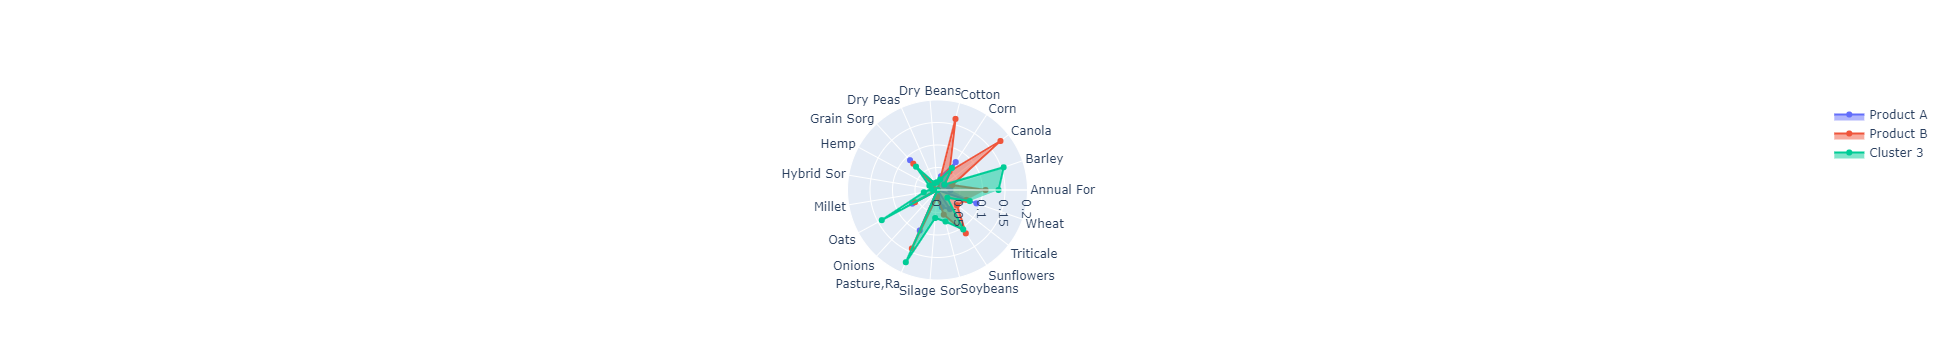

In [60]:
import plotly.graph_objects as go

categories = crop_columns

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=Cluster_1,
      theta=categories,
      fill='toself',
      name='Product A'
))
fig.add_trace(go.Scatterpolar(
      r=(Cluster_2), 
      theta=categories,
      fill='toself',
      name='Product B'
))

fig.add_trace(go.Scatterpolar(
      r=(Cluster_3), 
      theta=categories,
      fill='toself',
      name='Cluster 3'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, .2
            ]
    )),
  showlegend=True
)

fig.show()

In [48]:
Cluster_1 

[0.07409788558469915,
 0.09005369521202497,
 0.03938328729688929,
 0.09146522755107556,
 0.07409788558469915]

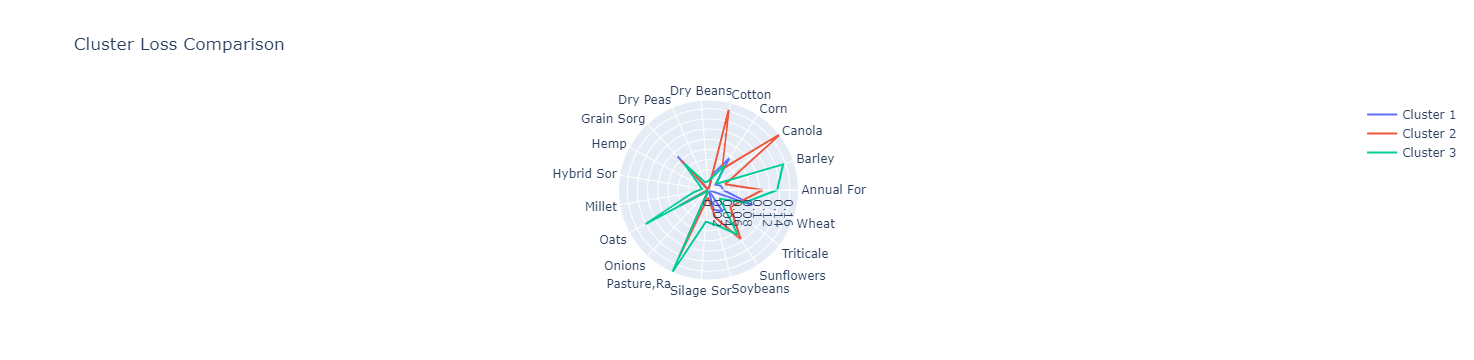

In [49]:
import plotly.graph_objects as go
import plotly.offline as pyo


categories = crop_columns
categories = [*categories, categories[0]]

Cluster_1, Cluster_2, Cluster_3 = cls_0, cls_1, cls_2
Cluster_1 = [*Cluster_1, Cluster_1[0]]
Cluster_2 = [*Cluster_2, Cluster_2[0]]
Cluster_3 = [*Cluster_3, Cluster_3[0]]


fig = go.Figure(
    data=[
        go.Scatterpolar(r=Cluster_1, theta=categories, name='Cluster 1'),
        go.Scatterpolar(r=Cluster_2, theta=categories, name='Cluster 2'),
        go.Scatterpolar(r=Cluster_3, theta=categories, name='Cluster 3')
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Cluster Loss Comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)
fig.show()
#pyo.plot(fig)


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (20).

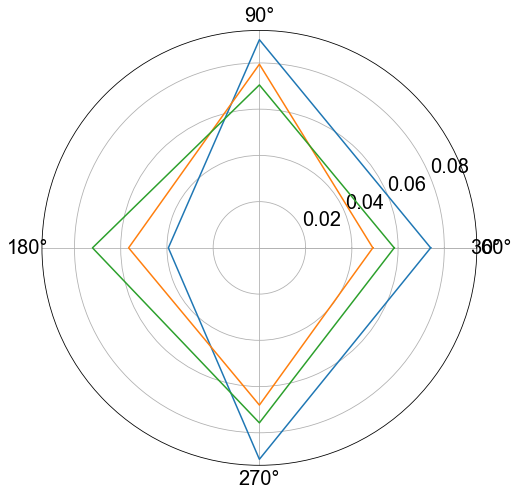

In [201]:

categories = crop_columns
categories = [*categories, categories[0]]

Cluster_1, Cluster_2, Cluster_3 = cls_0, cls_1, cls_2
Cluster_1 = [*Cluster_1, Cluster_1[0]]
Cluster_2 = [*Cluster_2, Cluster_2[0]]
Cluster_3 = [*Cluster_3, Cluster_3[0]]


label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(Cluster_1))

plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
plt.plot(label_loc, Cluster_1, label='Cluster_1')
plt.plot(label_loc, Cluster_2, label='Cluster_2')
plt.plot(label_loc, Cluster_3, label='Cluster_3')
#plt.title('Restaurant comparison', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()

In [50]:
loss = macr_cls.loc[macr_cls['macro_clus']== 0][['ARPI/SCO/E', 'All Other', 'Asian Soyb',
       'Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi', 'Fire', 'Flood',
       'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Mycotoxin',
       'Other (Sno', 'Plant Dise', 'Wind/Exces', 'ARPI/SCO/S', 'ARPI/SCO_1',
       'Falling Nu',]]

crop = macr_cls.loc[macr_cls['macro_clus']== 0][['Annual For',
       'Barley', 'Canola', 'Corn', 'Cotton', 'Dry Beans', 'Dry Peas',
       'Grain Sorg', 'Hemp', 'Hybrid Sor', 'Millet', 'Oats', 'Onions',
       'Pasture,Ra', 'Potatoes', 'Rye', 'Sesame', 'Silage Sor', 'Soybeans',
       'Sunflowers', 'Triticale', 'Wheat']]

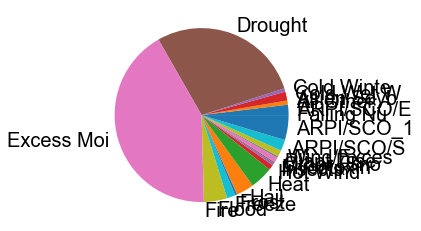

In [173]:

plt.pie(list(loss.T[0]*100), labels=list(loss.T[0].index))
#crop.T.plot.pie('subplots=True')
plt.show()

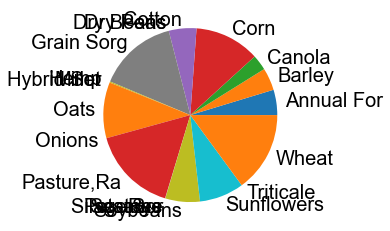

In [174]:
plt.pie(list(crop.T[0]*100), labels=list(crop.T[0].index))
#crop.T.plot.pie('subplots=True')
plt.show()

cls = merge_df.dissolve(by='unique_cluster')
cls=cls.reset_index()
cls.head(3)

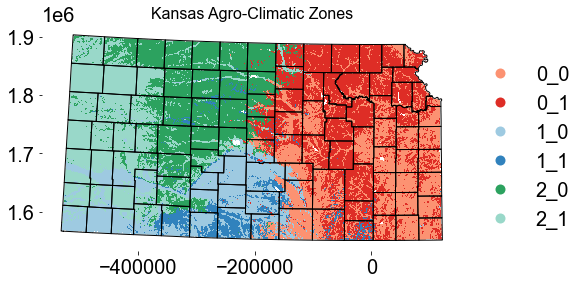

In [188]:
plt.figure(figsize=(8,10), constrained_layout=True) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.axes() #
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 20
 
plt.title('Kansas Agro-Climatic Zones', fontsize=16)
#cmap = mpl.colors.ListedColormap(["#deebf7","#08306b", '#fdbb84',"#feedde", "#e6550d", "#a1d99b", "#31a354", '#74c476'])
#cmap = mpl.colors.ListedColormap([ '#2171b5',#"#deebf7",#"#a6bddb",
#                                  '#fecc5c'#, '#e31a1c'#, '#e34a33'
 #                                 , "#bae4b3", "#238b45" ]) #"#31a354"

cmap = mpl.colors.ListedColormap(["#fc9272", "#de2d26", #'#fee5d9',
                                   '#9ecae1', '#3182bd', #,'#238b45',
                                   '#2ca25f', '#99d8c9'])#'#bdd7e7' '#74c476', '#238b45'  '#bae4b3'  '#edf8e9'

plot=merge_df.plot(column='unique_clu' , cmap=cmap, categorical=True,legend=True, ax=ax, legend_kwds=dict(bbox_to_anchor=(1.3,.9), frameon=False))

#s_.plot(ax=ax, color='none', edgecolor='black', linewidths =.5)

ks_map.plot(ax=ax, color='none', edgecolor='white', linewidths =1)
map_county.plot(ax=ax, color='none', edgecolor='black', linewidths =1)

plt.box(False)

plt.show()